# Natural Computing - Project
#### Submission by group 25 (Chihab Amghane, Max Driessen, Jordy Naus)

The code below uses the DEAP framework (https://github.com/deap/deap), which is a very intuitive framework for evolutionary algorithms and genetic programming.

## Imports

In [1]:
# DEAP
from deap import gp, base, tools, creator, algorithms

# Data processing and plotting
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Requirements for the algorithm
from operator import attrgetter
from functools import partial

# Standard python imports
import random, pickle, math, re, os, copy
import numpy as np

# Magic for inline plots
%matplotlib inline

## Helper functions

In [2]:
def exp(x):
    return np.exp(np.clip(x, -float('inf'), 709.))

## Global parameters

In [3]:
# Dataset parameters
DATASET = "MNIST" # choose from {"MNIST", "Fashion-MNIST"} 
N_CLASSES_TO_USE = 10 # at most 10
USE_NORMALIZATION = True
USE_ANTI_ALIASING = False

# Individual tree parameters
N_INITIAL_CONNECTIONS = 100
CONNECTIONS_CAPPED = True
MAX_CONNECTIONS = 300

# Fitness parameters
N_SAMPLES_TO_TEST = 200

# Evolution parameters
N_GENERATIONS = 500
POPULATION_SIZE = 100

TOURNAMENT_SIZE = 10
SIZE_TOURNAMENT = True
P_SMALLER_WINS = 0.65

P_ADD_CONNECTION = 0.5
P_REMOVE_CONNECTION = 0.3
P_ADD_NODE = 0.2
P_REMOVE_NODE = 0.2
P_CHANGE_OPERATOR = 0.3

# Filename parameters
RESULTS_FILENAME = "results.pkl"

## Loading preprocessed data

In [4]:
# Set the correct data filename
filename = f"{DATASET}-{N_CLASSES_TO_USE}{'-Norm' if USE_NORMALIZATION else ''}{'-AA' if USE_ANTI_ALIASING else ''}.pkl"

# If the data has not yet been preprocessed in the specified way, do so now
if not os.path.exists(os.path.join("data", filename)):
    print("Preprocessed dataset does not exist yet, creating now.")
    os.system(f"python Preprocessing.py -d {DATASET} -c {N_CLASSES_TO_USE}" + \
              f"{' --aa' if USE_ANTI_ALIASING else ''}{' --n' if USE_NORMALIZATION else ''}")

# Load the preprocessed data
with open(os.path.join("data", filename), "rb") as f:
    (X_train, Y_train), (X_test, Y_test) = pickle.load(f)

Preprocessed dataset does not exist yet, creating now.


## Defining operators

In [5]:
# Define operators (with a variable number of inputs)
def linear(*args):
    return sum(args)

def inverse(*args):
    return -sum(args)

def tanh(*args):
    return math.tanh(sum(args))

def sigmoid(*args):
    return 1.0/(1.0 + exp(-sum(args)))

def step(*args):
    return float(sum(args) >= 0)

def sine(*args):
    return math.sin(sum(args))

def cosine(*args):
    return math.cos(sum(args))

def gaussian(*args):
    return 0.5*sum(args)*(1.0+math.tanh(math.sqrt(2.0/math.pi)*(sum(args) + 0.044715*sum(args)**3)))
                          
def absolute(*args):
    return abs(sum(args))

In [6]:
# Define dictionary of functions for compiling
function_context = {'linear':linear, 'inverse':inverse, 'tanh':tanh, 'sigmoid':sigmoid, 'step':step, 
                    'sine':sine, 'cosine':cosine, 'gaussian':gaussian, 'absolute':absolute}

# Create lists of function and argument names
function_names = list(function_context.keys())
argument_names = [f"ARG{i}" for i in range(X_train.shape[1])]

## Defining individuals

##### Defining nodes

In [7]:
# Generic Node class
class Node:
    def __init__(self, name):
        self.name = name
        self.parents = []
        self.children = []
    
    def __str__(self):
        raise NotImplementedError("String function is only implemented for subclasses")

# Class for terminal nodes (inputs)
class TerminalNode(Node):
    def __init__(self, name):
        super().__init__(name)

    def __str__(self):
        return self.name

# Class for primitive nodes (internals + outputs)
class PrimitiveNode(Node):
    def __init__(self, name):
        super().__init__(name)

    def __str__(self):
        return f"{self.name}({', '.join([str(child) for child in self.children])})"

In [8]:
# Class for multi-output trees
class MultiClassTree:
    def __init__(self, n_inputs, n_outputs, n_initial_connections):
        # Initialize lists of input, output and internal nodes
        self.inputs = [TerminalNode(argument_names[i]) for i in range(n_inputs)]
        self.outputs = [PrimitiveNode("sigmoid") for _ in range(n_outputs)]
        self.internals = []
        
        # Add initial connections so that initial tree is valid
        self.n_connections = n_initial_connections
        for output in self.outputs:
            initial_children = random.choices(self.inputs, k=n_initial_connections)
            output.children.extend(initial_children)
            for child in initial_children:
                child.parents.append(output)

    def __str__(self):
        return f"MultiClassTree with {len(self.inputs)} inputs, " + \
                                   f"{len(self.outputs)} outputs and " + \
                                   f"{len(self.internals)} internal nodes.\n"
    
    # Retrieving output function strings
    def get_strings(self):
        try:
            return [str(output) for output in self.outputs]
        except RecursionError:
            print("Maximum recursion depth reached")
            return None

In [9]:
# Intialize the toolbox which will contain all sorts of functions for the genetic programming process
toolbox = base.Toolbox()

In [10]:
# Define classes for fitness and individuals (using DEAP's creator module)
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", MultiClassTree, fitness=creator.FitnessMax)

In [11]:
# Define how to initialize an individual or population
toolbox.register("individual", creator.Individual, X_train.shape[1], 
                               N_CLASSES_TO_USE, N_INITIAL_CONNECTIONS)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

## Fitness function

In [12]:
# Compiling a tree into a function
def compile_multiclasstree(tree):
    strings = tree.get_strings()
    funcs = [eval(f"lambda {', '.join(argument_names)}: {string}", function_context, {}) for string in strings]
    def func(args):
        return [f(*args) for f in funcs]
    return func

In [13]:
# Add compile function to toolbox
toolbox.register("compile", compile_multiclasstree)

In [14]:
# Define fitness function   
def fitness(individual, n_samples_to_test):
    # Compile the functions corresponding to the individual
    func = toolbox.compile(individual)
    
    # Create a list of samples to test, ensuring an equal number of samples from each class
    sample_indices = []
    n_samples_per_class = int(n_samples_to_test/N_CLASSES_TO_USE)
    for c in range(N_CLASSES_TO_USE):
        c_indices = np.where(Y_train == c)[0]
        assert len(c_indices) >= n_samples_per_class, \
            f"Class {c} has too few elements to reach the desired number of evaluation samples"
        sample_indices.extend(np.random.permutation(c_indices)[:n_samples_per_class])
    
    # Compute cross-entropy loss for each of the samples
    results = []
    for i in sample_indices:
        X_sample, Y_sample = X_train[i], Y_train[i]
        output = func(X_sample)
        results.append(np.argmax(output) == Y_sample)
    
    # Return the average cross-entropy loss
    return (np.average(results),)

In [15]:
# Add the fitness function to the toolbox
toolbox.register("evaluate", fitness, n_samples_to_test=N_SAMPLES_TO_TEST)

## Evolution components

##### Parent selection

In [16]:
# Redefine the tools.selDoubleTournament function for our multi-tree individuals (all comments from the original function have been removed to aid readability; the function remains unchanged 
# except for the usage of get_total_size instead of len (as well as some differences in imports and python version)
def selDoubleTournament(individuals, k, fitness_size, parsimony_size, fitness_first, fit_attr="fitness"):
    assert (1 <= parsimony_size <= 2), "Parsimony tournament size has to be in the range [1, 2]."

    def _sizeTournament(individuals, k, select):
        chosen = []
        for i in range(k):
            prob = parsimony_size / 2.
            ind1, ind2 = select(individuals, k=2)

            # This is the part that matters for our re-implementation: we use the total size of
            # all trees instead of the length of the individual, which is equal for all individuals
            if ind1.n_connections > ind2.n_connections:
                ind1, ind2 = ind2, ind1
            elif ind1.n_connections == ind2.n_connections:
                prob = 0.5

            chosen.append(ind1 if random.random() < prob else ind2)

        return chosen

    def _fitTournament(individuals, k, select):
        chosen = []
        for i in range(k):
            aspirants = select(individuals, k=fitness_size)
            chosen.append(max(aspirants, key=attrgetter(fit_attr)))
        return chosen

    if fitness_first:
        tfit = partial(_fitTournament, select=tools.selRandom)
        return _sizeTournament(individuals, k, tfit)
    else:
        tsize = partial(_sizeTournament, select=tools.selRandom)
        return _fitTournament(individuals, k, tsize)

In [17]:
# Define how to select parents (either a double tournament that controls for bloat or a single tournament that does not)
if SIZE_TOURNAMENT:
    toolbox.register("select", selDoubleTournament, fitness_size=TOURNAMENT_SIZE, 
                     parsimony_size=P_SMALLER_WINS*2, fitness_first=False)
else:
    toolbox.register("select", tools.selTournament, tournsize=TOURNAMENT_SIZE)

##### Mutation

In [18]:
def mutate(tree):
    
    tree = copy.deepcopy(tree)
    
    def _remove_connection():
        possible_parents = [t for t in tree.outputs + tree.internals if len(t.children) > 1]
        if not possible_parents:
            return
        parent = random.choice(possible_parents)
        child_to_remove = random.choice(parent.children)
        parent.children.remove(child_to_remove)
        child_to_remove.parents.remove(parent)
        tree.n_connections -= 1
    
    def _add_connection():
        def _is_ancestor(node1, node2):
            return node1 in [node2] + node2.parents or any([_is_ancestor(node1, node3) for node3 in node2.parents])
        valid_child = False
        while not valid_child:
            parent = random.choice(tree.outputs + tree.internals)
            child = random.choice(tree.inputs + tree.internals)
            valid_child = not _is_ancestor(child, parent)
        child.parents.append(parent)
        parent.children.append(child)
        tree.n_connections += 1
        
    def _add_node():
        parent = random.choice(tree.outputs + tree.internals)
        children = random.sample(parent.children, random.randint(1, len(parent.children)))
        [parent.children.remove(child) for child in children]

        node = PrimitiveNode(random.choice(function_names))
        parent.children.append(node)
        node.parents.append(parent)
        node.children.extend(children)
        for child in children:
            child.parents.append(node)
        tree.internals.append(node)
        tree.n_connections += 1

    def _remove_node():
        if not tree.internals:
            return
        node = random.choice(tree.internals)
        for parent in node.parents:
            parent.children.extend(node.children)
        for child in node.children:
            child.parents.extend(node.parents)
        tree.internals.remove(node)
        connection_change = len(node.children) * (len(node.parents)-1) - len(node.parents)
        tree.n_connections += connection_change

    def _change_operator():
        if not tree.internals:
            return
        node = random.choice(tree.internals)
        node.name = random.choice(function_names)
        
    if random.random() < P_ADD_CONNECTION:
        _add_connection()
    if random.random() < P_REMOVE_CONNECTION:
        _remove_connection()
    if random.random() < P_ADD_NODE:
        _add_node()
    if random.random() < P_REMOVE_NODE:
        _remove_node()
    if random.random() < P_CHANGE_OPERATOR:
        _change_operator()
        
    return tree,

In [19]:
# Add the mutation ("mutate") function to the toolbox
toolbox.register("mutate", mutate)

##### Height boundary

In [20]:
# Define upper limits for height of trees (if limit is exceeded, a random parent is used instead)
if CONNECTIONS_CAPPED:
    toolbox.decorate("mutate", gp.staticLimit(key=lambda ind: ind.n_connections, max_value=MAX_CONNECTIONS))

## Defining statistics

In [21]:
# Describe which kinds of statistics to keep track of
stats_fit = tools.Statistics(key = lambda ind: ind.fitness.values)
stats_connections = tools.Statistics(key = lambda ind: ind.n_connections)
mstats = tools.MultiStatistics(fitness=stats_fit, connections=stats_connections)

In [22]:
# Describe metrics to keep track of for each statistic
mstats.register("avg", np.mean)
mstats.register("std", np.std)
mstats.register("min", np.min)
mstats.register("max", np.max)

## Running the genetic programming algorithm

In [23]:
pop = toolbox.population(POPULATION_SIZE)
hof = tools.HallOfFame(1)
pop, log = algorithms.eaSimple(population=pop, toolbox=toolbox, cxpb=0.0, mutpb=1.0, 
                               ngen=N_GENERATIONS, stats=mstats, halloffame=hof, verbose=True)

   	      	                connections                	                     fitness                     
   	      	-------------------------------------------	-------------------------------------------------
gen	nevals	avg	gen	max	min	nevals	std	avg   	gen	max 	min  	nevals	std      
0  	100   	100	0  	100	100	100   	0  	0.1081	0  	0.21	0.035	100   	0.0382281
1  	100   	100.32	1  	102	99 	100   	0.773046	0.15415	1  	0.26	0.075	100   	0.0382299
2  	100   	100.16	2  	103	98 	100   	0.976934	0.1817 	2  	0.24	0.09 	100   	0.0309129
3  	100   	100.14	3  	102	98 	100   	0.905759	0.1899 	3  	0.285	0.1  	100   	0.0350141
4  	100   	100.48	4  	103	98 	100   	1.15308 	0.20785	4  	0.28 	0.135	100   	0.0296838
5  	100   	100.64	5  	104	98 	100   	1.42492 	0.2053 	5  	0.27 	0.115	100   	0.0253162
6  	100   	101.82	6  	174	97 	100   	7.42884 	0.20965	6  	0.295	0.16 	100   	0.0259254
7  	100   	101.05	7  	105	99 	100   	1.26787 	0.204  	7  	0.285	0.155	100   	0.0256125
8  	100   	101.54	8  	105	99 

92 	100   	117.97	92 	167	109	100   	12.8386 	0.3193 	92 	0.4  	0.23 	100   	0.0333768
93 	100   	118.85	93 	190	110	100   	13.5029 	0.3286 	93 	0.41 	0.24 	100   	0.0305866
94 	100   	117.1 	94 	190	111	100   	10.7308 	0.3252 	94 	0.405	0.195	100   	0.0324262
95 	100   	116.97	95 	190	110	100   	10.8917 	0.32525	95 	0.395	0.235	100   	0.0299865
96 	100   	115.37	96 	160	110	100   	7.91158 	0.334  	96 	0.41 	0.24 	100   	0.0309597
97 	100   	118.39	97 	158	110	100   	10.2547 	0.3219 	97 	0.4  	0.21 	100   	0.0335766
98 	100   	120.15	98 	267	111	100   	18.7133 	0.32605	98 	0.41 	0.25 	100   	0.0333863
99 	100   	121.41	99 	267	111	100   	20.5578 	0.3225 	99 	0.415	0.19 	100   	0.0352952
100	100   	126.35	100	269	110	100   	30.7657 	0.3244 	100	0.385	0.22 	100   	0.0321969
101	100   	124.67	101	162	110	100   	15.5474 	0.3253 	101	0.42 	0.23 	100   	0.0325639
102	100   	132.87	102	270	110	100   	23.4276 	0.33295	102	0.425	0.25 	100   	0.0331443
103	100   	129.71	103	172	110	100   	16.094

187	100   	130.93	187	208	116	100   	15.6431 	0.36065	187	0.43 	0.265	100   	0.031366 
188	100   	128.31	188	203	115	100   	14.791  	0.361  	188	0.44 	0.17 	100   	0.0376895
189	100   	131.73	189	292	115	100   	27.3492 	0.36105	189	0.455	0.26 	100   	0.0340463
190	100   	135.62	190	293	114	100   	32.4795 	0.35465	190	0.42 	0.21 	100   	0.0393717
191	100   	133.22	191	199	113	100   	17.2288 	0.3621 	191	0.435	0.225	100   	0.0382896
192	100   	131.28	192	293	113	100   	22.3755 	0.3608 	192	0.435	0.25 	100   	0.0300892
193	100   	127.34	193	206	112	100   	15.1659 	0.35625	193	0.435	0.24 	100   	0.0335289
194	100   	132.7 	194	226	112	100   	17.8048 	0.35815	194	0.42 	0.29 	100   	0.0308841
195	100   	139.96	195	293	112	100   	29.1667 	0.35375	195	0.465	0.25 	100   	0.0376123
196	100   	135.24	196	169	113	100   	14.1881 	0.35775	196	0.425	0.225	100   	0.0347302
197	100   	136.96	197	207	117	100   	16.3719 	0.35965	197	0.46 	0.275	100   	0.0341559
198	100   	133.22	198	176	117	100   	14.649

282	100   	132.31	282	216	124	100   	11.6445 	0.3644 	282	0.455	0.195	100   	0.0384986
283	100   	133.62	283	213	124	100   	15.0518 	0.3747 	283	0.46 	0.32 	100   	0.0268498
284	100   	131.56	284	175	124	100   	8.96585 	0.3671 	284	0.43 	0.28 	100   	0.0275607
285	100   	132.03	285	213	123	100   	11.5589 	0.368  	285	0.43 	0.29 	100   	0.0284517
286	100   	134.17	286	218	122	100   	14.8304 	0.36365	286	0.435	0.18 	100   	0.0397483
287	100   	136.81	287	213	123	100   	16.2694 	0.36535	287	0.455	0.295	100   	0.0324211
288	100   	137.5 	288	221	125	100   	17.1397 	0.37185	288	0.44 	0.26 	100   	0.0355855
289	100   	133.82	289	221	126	100   	9.60873 	0.3622 	289	0.43 	0.215	100   	0.0368125
290	100   	140.4 	290	231	125	100   	22.2342 	0.3635 	290	0.435	0.2  	100   	0.0334328
291	100   	140.14	291	221	125	100   	21.1182 	0.3671 	291	0.475	0.23 	100   	0.0351723
292	100   	135.44	292	221	125	100   	13.8162 	0.37035	292	0.45 	0.2  	100   	0.0347797
293	100   	136.81	293	222	126	100   	16.743

377	100   	137.95	377	209	128	100   	14.1027 	0.3857 	377	0.465	0.29 	100   	0.0336676
378	100   	140.86	378	210	127	100   	17.8578 	0.3793 	378	0.475	0.22 	100   	0.0359724
379	100   	141.4 	379	217	128	100   	20.5917 	0.37645	379	0.455	0.23 	100   	0.0340463
380	100   	145.29	380	287	130	100   	26.3163 	0.38225	380	0.455	0.17 	100   	0.0407393
381	100   	148.47	381	261	130	100   	28.6295 	0.3878 	381	0.465	0.285	100   	0.0321039
382	100   	144.53	382	263	130	100   	24.717  	0.38315	382	0.455	0.29 	100   	0.0356417
383	100   	151.09	383	273	130	100   	32.2264 	0.3855 	383	0.46 	0.27 	100   	0.0342746
384	100   	146.09	384	220	131	100   	19.1489 	0.3811 	384	0.49 	0.255	100   	0.038811 
385	100   	146.75	385	224	131	100   	21.9824 	0.3878 	385	0.475	0.18 	100   	0.0414145
386	100   	139.48	386	217	131	100   	12.9209 	0.38345	386	0.465	0.235	100   	0.0349048
387	100   	144.5 	387	204	130	100   	16.162  	0.38065	387	0.455	0.27 	100   	0.0385529
388	100   	146.77	388	263	129	100   	23.966

472	100   	157   	472	248	143	100   	15.6538 	0.3972 	472	0.48 	0.28 	100   	0.0309542
473	100   	154.96	473	196	143	100   	10.5602 	0.40135	473	0.465	0.26 	100   	0.0359782
474	100   	155.81	474	251	142	100   	16.0416 	0.40135	474	0.465	0.265	100   	0.0333606
475	100   	153.56	475	224	144	100   	10.6201 	0.4004 	475	0.5  	0.275	100   	0.0370451
476	100   	155.85	476	293	143	100   	23.5029 	0.40015	476	0.46 	0.245	100   	0.0390157
477	100   	151.07	477	180	142	100   	8.01905 	0.4004 	477	0.48 	0.26 	100   	0.0403155
478	100   	153.17	478	290	142	100   	19.5187 	0.4012 	478	0.475	0.235	100   	0.038263 
479	100   	153.24	479	223	141	100   	15.4778 	0.39965	479	0.495	0.26 	100   	0.0418704
480	100   	156.17	480	236	141	100   	23.0612 	0.39925	480	0.51 	0.26 	100   	0.0392006
481	100   	154.8 	481	243	141	100   	22.6632 	0.4008 	481	0.49 	0.295	100   	0.033784 
482	100   	160.76	482	291	141	100   	32.3191 	0.39235	482	0.47 	0.225	100   	0.0413005
483	100   	160.42	483	244	139	100   	32.118

In [24]:
# Store results
with open(RESULTS_FILENAME, "wb") as f:
    pickle.dump((pop, log, hof), f)

## Plotting statistics

In [25]:
# Extract generation IDs, minimum fitnesses and average total heights per generation
gen = log.select("gen")
fitness_best = log.chapters["fitness"].select("max") 
conn_avg = log.chapters["connections"].select("avg")

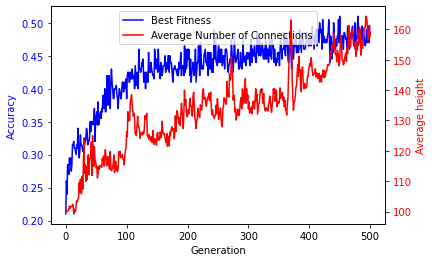

In [26]:
# Plot line for minimum fitness
fig, fit_ax = plt.subplots()
fit_line = fit_ax.plot(gen, fitness_best, "b-", label="Best Fitness")
fit_ax.set_xlabel("Generation")
fit_ax.set_ylabel(f"Accuracy", color="b")
for tl in fit_ax.get_yticklabels():
    tl.set_color("b")

# Plot line for average total height
height_ax = fit_ax.twinx()
height_line = height_ax.plot(gen, conn_avg, "r-", label="Average Number of Connections")
height_ax.set_ylabel("Average height", color="r")
for tl in height_ax.get_yticklabels():
    tl.set_color("r")

# Add legend
lines = fit_line + height_line
labs = [l.get_label() for l in lines]
fit_ax.legend(lines, labs, loc="upper center")

# Show the result
plt.show()

## Inspecting the best individual

In [27]:
best_ind = hof[0]
print(f"Fitness of best individual: {best_ind.fitness}")

Fitness of best individual: (0.51,)


##### Printing trees

In [28]:
# Print the trees of the best individual
for string in best_ind.get_strings():
    print(f"{string}\n")

sigmoid(ARG86, ARG70, ARG22, ARG33, ARG235, ARG93, ARG27, ARG116, ARG238, ARG72, ARG191, ARG160, ARG140, ARG94, ARG28, ARG133, ARG101, ARG154, ARG184, ARG122, ARG106, ARG164, ARG207, ARG143, ARG102, ARG64, ARG242, linear(ARG8, ARG185, ARG133, ARG105, ARG94, ARG206, ARG180, ARG156, ARG74, ARG59, ARG146, ARG65, ARG226, ARG20, ARG45, ARG230, ARG53, ARG224, ARG73, ARG109, ARG78, ARG241, ARG124, ARG138, ARG9, ARG197, ARG254, ARG127, ARG230, ARG222, ARG220, ARG83, ARG180, ARG207, ARG57, ARG10, ARG254, ARG245, ARG111, ARG192, ARG144, ARG75, ARG186, ARG143, ARG133, ARG79, linear(ARG184, ARG170, ARG92, ARG207, ARG249, ARG6, ARG38, ARG157, ARG144, ARG199, ARG178, ARG21, ARG131, ARG5, ARG155), ARG149, ARG192, ARG25, tanh(ARG219)), ARG31, linear(ARG102, ARG128, ARG41, ARG207, ARG186, ARG107, ARG223, ARG110, ARG31, ARG181))

sigmoid(ARG15, tanh(ARG49, ARG30, ARG191, ARG80, ARG64, ARG36, ARG54, ARG98, linear(ARG11, ARG208, ARG198, ARG218, ARG59, ARG211, ARG10, ARG63, ARG186, ARG76, ARG89, ARG134, AR

##### Computing training & validation accuracy

In [29]:
# Retrieving predictions from an individual
def get_predictions(individual, X):
    func = compile_multiclasstree(individual)
    predictions = []
    for i in range(X.shape[0]):
        outputs_i = func(X[i])
        predictions.append(np.argmax(outputs_i))
    return predictions

In [30]:
# Retrieve predictions of the best individual on the training and validation sets
Y_train_pred = get_predictions(best_ind, X_train)
Y_test_pred = get_predictions(best_ind, X_test)

In [31]:
# Compute accuracy of predictions
def compute_accuracy(Y_pred, Y_true):
    n_correct = np.sum(Y_pred == Y_true)
    return n_correct/Y_true.shape[0]

In [32]:
# Print training and validation accuracies of the best individual
print(f"Training accuracy: {compute_accuracy(Y_train_pred, Y_train)}")
print(f"Validation accuracy: {compute_accuracy(Y_test_pred, Y_test)}")

Training accuracy: 0.40865
Validation accuracy: 0.4111


##### Confusion matrices

In [33]:
# Compute confusion matrices
cm_train = confusion_matrix(Y_train, Y_train_pred, labels=range(N_CLASSES_TO_USE))
cm_test = confusion_matrix(Y_test, Y_test_pred, labels=range(N_CLASSES_TO_USE))

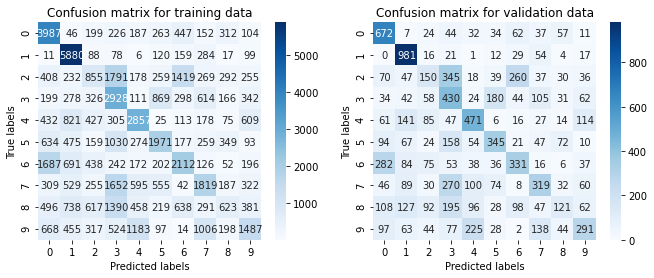

In [34]:
# Create figure
fig, ax = plt.subplots(1,2, figsize=(11,4))

# Plot confusion matrix for training data
sns.heatmap(cm_train, annot=True, fmt='g', ax=ax[0], cmap="Blues")
ax[0].set_xlabel('Predicted labels')
ax[0].set_ylabel('True labels')
ax[0].set_title('Confusion matrix for training data')

# Plot confusion matrix for validation data
sns.heatmap(cm_test, annot=True, fmt='g', ax=ax[1], cmap="Blues")
ax[1].set_xlabel('Predicted labels')
ax[1].set_ylabel('True labels')
ax[1].set_title('Confusion matrix for validation data')

# Show the result
plt.show()

##### Used features

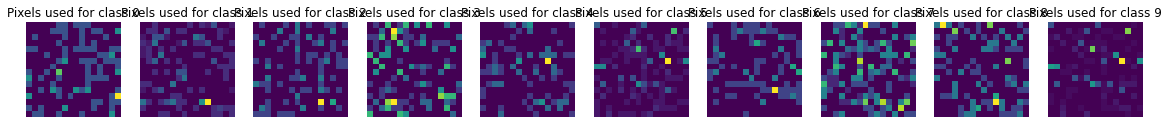

In [35]:
# Create plots of the inputs (pixels) used in the tree of the best individual for each class 
fig, ax = plt.subplots(1, N_CLASSES_TO_USE, figsize=(20,20/N_CLASSES_TO_USE))
for i, tree in enumerate(best_ind.get_strings()):
    inputs_used = list(map(int, re.findall("[0-9]+", str(tree))))
    input_tallies = np.zeros(X_train.shape[1])
    for arg in inputs_used:
        input_tallies[arg] += 1
    img_shape = int(math.sqrt(X_train.shape[1]))
    ax[i].imshow(input_tallies.reshape(img_shape, img_shape))
    ax[i].axis("off")
    ax[i].set_title(f"Pixels used for class {i}") 
plt.show()